In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

## Load and preapare Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("keplersmachines/kepler-labelled-time-series-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'kepler-labelled-time-series-data' dataset.
Path to dataset files: /kaggle/input/kepler-labelled-time-series-data


In [ ]:
print("Loading datasets...")
try:
    train_df = pd.read_csv(f"{path}/exoTrain.csv")
    test_df = pd.read_csv(f"{path}/exoTest.csv")
    print("exoTrain.csv loaded successfully!")
    print("exoTest.csv loaded successfully!")
except FileNotFoundError:
    print("ERROR: Files not found. Please ensure 'exoTrain.csv' and 'exoTest.csv' are in the directory specified by 'path'.")
    exit()

Loading datasets...
exoTrain.csv loaded successfully!
exoTest.csv loaded successfully!


In [ ]:
train_df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [ ]:
test_df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


In [ ]:
# Convert Labels: (1=Non-Planet, 2=Planet) -> (0=Non-Planet, 1=Planet)
y_train = train_df['LABEL'] - 1
X_train = train_df.drop('LABEL', axis=1)

y_test = test_df['LABEL'] - 1
X_test = test_df.drop('LABEL', axis=1)

## Applying Fourier Transform

In [ ]:
print("Applying Fourier Transform to convert time into frequency domain...")

def apply_fft(df):
    # Apply Real FFT (Fast Fourier Transform) row-wise
    fft_data = np.abs(np.fft.rfft(df, axis=1))
    return pd.DataFrame(fft_data)

# Transform features
X_train_fft = apply_fft(X_train)
X_test_fft = apply_fft(X_test)

Applying Fourier Transform to convert time into frequency domain...


In [ ]:
X_train_fft.head()

,0,1,2,3,4,5,6,7,8,9,...,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598
0,31822.48,3542.697260,55671.612807,52952.701956,200751.502826,29353.124433,25093.521120,16709.544467,28812.723753,25559.772897,...,4594.761549,2005.314547,1541.084129,3540.200214,3705.331326,4349.670428,395.824196,2953.704522,5140.522704,6405.865475
1,23747.10,18904.034831,23034.013754,23943.701671,13819.563577,20765.092016,17303.647198,7401.036438,8735.502062,8872.865012,...,1218.487756,243.529914,827.849393,1406.992947,1858.756789,1329.533175,1404.210412,1797.490235,720.484481,1232.103224
2,26180.51,143610.487591,41912.294689,365999.616787,104066.520704,189543.713858,123398.774919,83153.412884,22577.194163,99916.175640,...,806.189384,1373.805544,2733.179365,2207.305916,1412.864611,3080.729313,2357.973475,2400.243267,6682.548093,4781.096791
3,14855.14,12371.439885,33309.457851,69042.125217,64290.918441,172076.407434,49458.284691,45511.563319,35061.742616,21291.359595,...,1677.904668,777.329823,189.844953,380.085298,1252.361289,677.090727,933.320653,730.176141,1645.081227,855.544590
4,45527.39,310414.084694,140433.251401,400661.916141,406211.307176,283810.829694,319055.791578,79144.154130,99624.063739,189609.298602,...,521.093981,6006.890959,3471.588918,880.277921,1721.021786,3237.072927,3046.730648,3759.413429,3707.198263,9188.679655


In [ ]:
X_test_fft.head()

,0,1,2,3,4,5,6,7,8,9,...,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598
0,2336.44,1.010599e+04,17673.365899,7843.480229,6003.294139,7233.286852,7642.207632,3528.158697,3507.134893,4162.501513,...,860.633397,488.414591,538.954649,1317.867625,327.015932,1448.507410,780.366575,1474.984147,1245.274308,1791.135588
1,305036.52,1.941835e+06,611030.236658,401110.349063,253011.570670,230486.625738,901922.049009,386620.591840,382749.490065,425318.824620,...,23675.775798,27892.391147,28815.222424,16281.853425,18291.763904,6295.872770,13670.838766,22852.512317,37022.910596,40801.995865
2,19294.33,1.333539e+05,34843.973448,15267.356940,15379.377836,60563.004643,31069.829077,29142.625941,18886.810358,4302.154612,...,1682.478568,998.174356,2177.514128,1871.496158,3254.384849,1732.948842,3229.522552,3970.111759,2028.997610,2948.635559
3,198318.67,1.224174e+05,67392.748075,16762.498635,53518.455670,66570.114293,62249.247191,19723.361376,28755.653151,20904.330935,...,4473.769051,4325.354016,3709.099912,1028.508266,1636.762495,5952.018210,5685.231236,6647.859878,4084.228985,3349.347039
4,75670.79,1.622826e+04,27147.827152,29117.750443,63294.075858,90211.529159,40888.462531,68733.049795,33646.127913,19327.208402,...,2655.234621,258.756947,2252.723777,2290.389074,1228.722780,3047.838088,3973.807955,1716.782208,2135.019334,3005.561091


In [ ]:
# Remove the first column (DC component/Mean brightness) as it's just an offset
X_train_fft = X_train_fft.iloc[:, 1:]
X_test_fft = X_test_fft.iloc[:, 1:]

print(f"FFT Applied. New Feature Shape: {X_train_fft.shape}")

FFT Applied. New Feature Shape: (5087, 1598)


## Scaling and balancing dataset

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fft)
X_test_scaled = scaler.transform(X_test_fft)

In [ ]:
# Apply SMOTE to training data (Synthetic Minority Oversampling Technique)
print("Applying SMOTE to balance training data...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

Applying SMOTE to balance training data...


In [ ]:
# Compute Class Weights for preventing model from ignoring real planets
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weight_dict}")

Class Weights: {0: np.float64(0.5036633663366337), 1: np.float64(68.74324324324324)}


## Building the ANN model

In [ ]:
model = models.Sequential([
    # Input Layer matching FFT dimensions
    layers.Dense(1024, input_shape=(X_train_scaled.shape[1],)),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Hidden Layer 1
    layers.Dense(512),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Hidden Layer 2
    layers.Dense(128),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.3),

    # Output Layer
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
# Low learning rate for stability
optimizer = keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

## Training the model

In [ ]:
print("\nStarting Training...")
history = model.fit(
    X_train_res, y_train_res,
    validation_split=0.1,
    epochs=60,
    batch_size=64,
    class_weight=class_weight_dict,
    verbose=2
)


Starting Training...
Epoch 1/60
143/143 - 9s - 63ms/step - accuracy: 0.6089 - loss: 22.3369 - val_accuracy: 1.0000 - val_loss: 0.4394
Epoch 2/60
143/143 - 0s - 3ms/step - accuracy: 0.5587 - loss: 7.6116 - val_accuracy: 1.0000 - val_loss: 0.2308
Epoch 3/60
143/143 - 0s - 3ms/step - accuracy: 0.5220 - loss: 4.5642 - val_accuracy: 1.0000 - val_loss: 0.1496
Epoch 4/60
143/143 - 1s - 4ms/step - accuracy: 0.5119 - loss: 2.9290 - val_accuracy: 1.0000 - val_loss: 0.1376
Epoch 5/60
143/143 - 1s - 4ms/step - accuracy: 0.5059 - loss: 2.3032 - val_accuracy: 1.0000 - val_loss: 0.1012
Epoch 6/60
143/143 - 1s - 4ms/step - accuracy: 0.5052 - loss: 2.1295 - val_accuracy: 1.0000 - val_loss: 0.1212
Epoch 7/60
143/143 - 1s - 4ms/step - accuracy: 0.5036 - loss: 1.7819 - val_accuracy: 1.0000 - val_loss: 0.0592
Epoch 8/60
143/143 - 1s - 4ms/step - accuracy: 0.5003 - loss: 1.7762 - val_accuracy: 1.0000 - val_loss: 0.1356
Epoch 9/60
143/143 - 1s - 4ms/step - accuracy: 0.4997 - loss: 1.6759 - val_accuracy: 1.0

## Threshold tuning



In [ ]:
def calculate_metrics_at_threshold(y_true, y_probs, threshold):
    """
    Calculates TP, FP, TN, FN and Accuracy for a specific threshold.
    """
    preds = (y_probs > threshold).astype(int).flatten()
    acc = accuracy_score(y_true, preds)
    cm = confusion_matrix(y_true, preds)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle edge cases (all 0s or all 1s)
        if preds.sum() == 0:
             tp = 0; fp = 0
        else:
             tp = sum(y_true); fp = len(y_true) - tp

    return acc, tp, fp

In [ ]:
def find_best_threshold(y_true, y_probs, thresholds, min_tp=4, max_fp=50):
    """
    Scans thresholds to find the best one based on strict criteria:
    1. True Positives >= min_tp
    2. False Positives <= max_fp
    3. Highest Accuracy among those that pass 1 & 2.
    """
    print(f"\nOptimization Target: Find Real Planets >= {min_tp} | False Alarms <= {max_fp}")
    print(f"{'THRESHOLD':<12} | {'ACCURACY':<10} | {'REAL PLANETS':<14} | {'FALSE ALARMS':<12}")
    print("-" * 65)

    best_threshold = 0.5
    best_acc = 0.0
    criteria_met = False

    # Store the best metrics found so far
    final_tp = 0
    final_fp = 0

    for threshold in thresholds:
        acc, tp, fp = calculate_metrics_at_threshold(y_true, y_probs, threshold)

        print(f" > {threshold:<9} | {acc*100:<9.2f}% | {tp:<14} | {fp:<12}")

        # Apply the specific criteria
        if tp >= min_tp and fp <= max_fp:
            criteria_met = True

            # If criteria met, maximize accuracy
            if acc > best_acc:
                best_acc = acc
                best_threshold = threshold
                final_tp = tp
                final_fp = fp

    return best_threshold, best_acc, criteria_met, final_tp, final_fp

In [ ]:
# 1. Get Probabilities
print("\nGenerating predictions...")
y_pred_probs = model.predict(X_test_scaled, verbose=0)

# 2. Define Parameters
thresholds_list = [0.50, 0.80, 0.90, 0.95, 0.98, 0.99, 0.991, 0.993, 0.994, 0.995, 0.997, 0.999]
MIN_PLANETS = 5
MAX_BAD_FLAGS = 50

# 3. Run Optimization
best_thresh, best_acc, success, tp, fp = find_best_threshold(
    y_test,
    y_pred_probs,
    thresholds_list,
    min_tp=MIN_PLANETS,
    max_fp=MAX_BAD_FLAGS
)

# 4. Final Output
print("="*65)
if success:
    print(f"BEST THRESHOLD FOUND: {best_thresh}")
    print(f"   - Planets Found: {tp}")
    print(f"   - False Alarms:  {fp}")
    print(f"OPTIMIZED ACCURACY: {best_acc*100:.2f}%")
else:
    print("No threshold met the strict criteria.")


Generating predictions...

Optimization Target: Find Real Planets >= 5 | False Alarms <= 50
THRESHOLD    | ACCURACY   | REAL PLANETS   | FALSE ALARMS
-----------------------------------------------------------------
 > 0.5       | 1.93     % | 5              | 559         
 > 0.8       | 4.21     % | 5              | 546         
 > 0.9       | 9.47     % | 5              | 516         
 > 0.95      | 17.02    % | 5              | 473         
 > 0.98      | 37.19    % | 5              | 358         
 > 0.99      | 93.68    % | 5              | 36          
 > 0.991     | 95.09    % | 5              | 28          
 > 0.993     | 96.84    % | 5              | 18          
 > 0.994     | 97.72    % | 5              | 13          
 > 0.995     | 97.54    % | 4              | 13          
 > 0.997     | 98.60    % | 4              | 7           
 > 0.999     | 98.77    % | 3              | 5           
BEST THRESHOLD FOUND: 0.994
   - Planets Found: 5
   - False Alarms:  13
OPTIMIZED ACCU

In [ ]:
y_pred_final = (y_pred_probs > best_thresh).astype(int).flatten()

## Evaluating the model

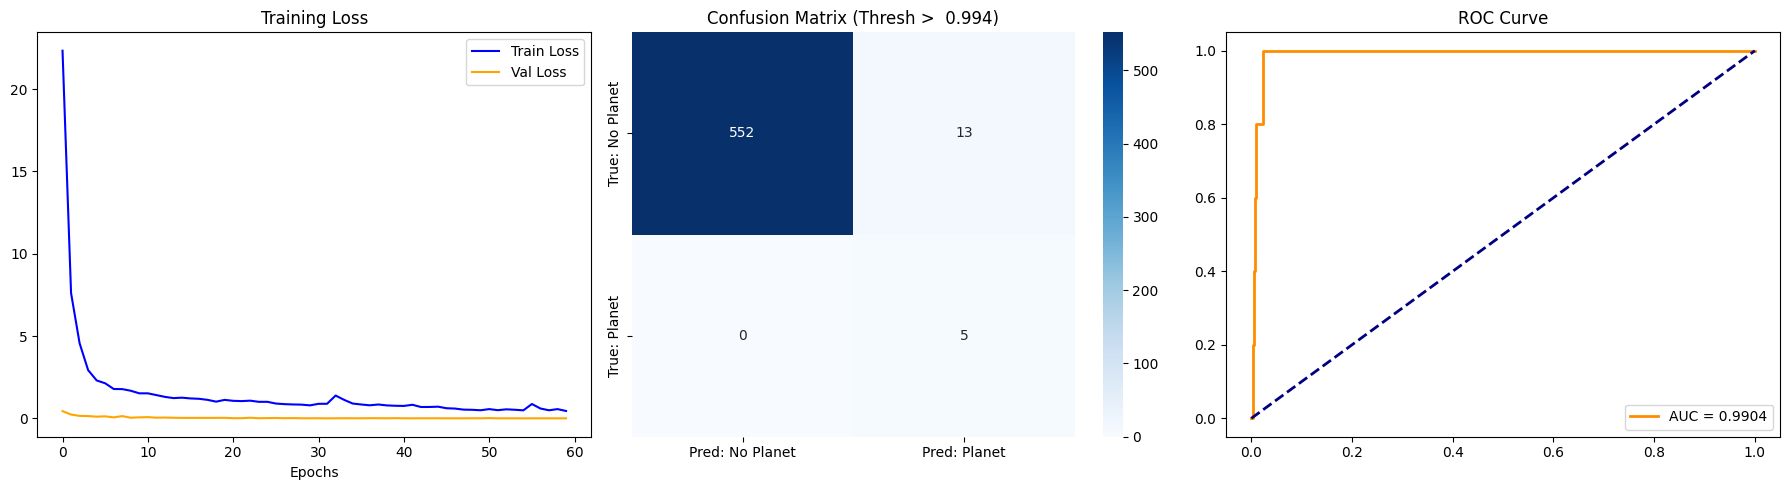

In [ ]:
# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Loss Curve
axes[0].plot(history.history['loss'], label='Train Loss', color='blue')
axes[0].plot(history.history['val_loss'], label='Val Loss', color='orange')
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend()

# 2. Confusion Matrix (Using Best Threshold)
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Pred: No Planet', 'Pred: Planet'],
            yticklabels=['True: No Planet', 'True: Planet'])
axes[1].set_title(f'Confusion Matrix (Thresh > {best_thresh: })')

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
auc_score = roc_auc_score(y_test, y_pred_probs)
axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.4f}')
axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2].set_title('ROC Curve')
axes[2].legend()

plt.tight_layout()
plt.show()

## Final Model Summary and Comparison

In [ ]:
print("\n" + "="*60)
print("                  MODEL SUMMARY")
print("="*60)
print(f"Final Test Accuracy:   {best_acc*100:.2f}%  (at threshold > {best_thresh:})")
auc_score_original = roc_auc_score(y_test, y_pred_probs)
print(f"ROC AUC Score:         {auc_score_original:.4f}")
print("-" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=['No Planet', 'Planet']))


                  MODEL SUMMARY
Final Test Accuracy:   97.72%  (at threshold > 0.994)
ROC AUC Score:         0.9904
------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

   No Planet       1.00      0.98      0.99       565
      Planet       0.28      1.00      0.43         5

    accuracy                           0.98       570
   macro avg       0.64      0.99      0.71       570
weighted avg       0.99      0.98      0.98       570

